In [58]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [2]:
# Create the dataframe, forcing the names of the rows and columns to make it easier to work with
df = pd.read_csv('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv', 
                 index_col='City',
                 names=['City', 'Population', 'Violent Crime', 'Murder', 'Rape 1', 'Rape 2',
                       'Robbery', 'Aggravated assault', 'Property_crime', 'Burglary',
                       'Larceny-theft', 'Motor vehicle theft', 'Arson']
                )
df.head()

,Population,Violent Crime,Murder,Rape 1,Rape 2,Robbery,Aggravated assault,Property_crime,Burglary,Larceny-theft,Motor vehicle theft,Arson
City,,,,,,,,,,,,
City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0
Addison Town and Village,"2,577",3,0,NaN,0,0,3,24,3,20,1,0
Akron Village,"2,846",3,0,NaN,0,0,3,16,1,15,0,0
Albany,"97,956",791,8,NaN,30,227,526,"4,090",705,"3,243",142,NaN


In [3]:
# Remove the columns we don't need and the excess first row
df = df.drop(index='City',
        columns=['Violent Crime', 'Rape 1', 'Rape 2', 'Aggravated assault', 
                'Burglary', 'Larceny-theft', 'Motor vehicle theft', 'Arson']
       )

In [4]:
# Remove the commas from the columns so that we can chance from strings to numbers
df.Population = df.Population.str.replace(',', '')
df.Murder = df.Murder.str.replace(',', '')
df.Robbery = df.Robbery.str.replace(',', '')
df.Property_crime = df.Property_crime.str.replace(',', '')
df.head()

,Population,Murder,Robbery,Property_crime
City,,,,
Adams Village,1861,0,0,12
Addison Town and Village,2577,0,0,24
Akron Village,2846,0,0,16
Albany,97956,8,227,4090
Albion Village,6388,0,4,223


In [5]:
# Change from strings to numbers
df.Population = pd.to_numeric(df.Population, errors='coerce')
df.Murder = pd.to_numeric(df.Murder, errors='coerce')
df.Robbery = pd.to_numeric(df.Robbery, errors='coerce')
df.Property_crime = pd.to_numeric(df.Property_crime, errors='coerce')
df.head(10)

,Population,Murder,Robbery,Property_crime
City,,,,
Adams Village,1861,0,0,12
Addison Town and Village,2577,0,0,24
Akron Village,2846,0,0,16
Albany,97956,8,227,4090
Albion Village,6388,0,4,223
Alfred Village,4089,0,3,46
Allegany Village,1781,0,0,10
Amherst Town,118296,1,31,2118
Amityville Village,9519,0,4,210


c:\users\ross last\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


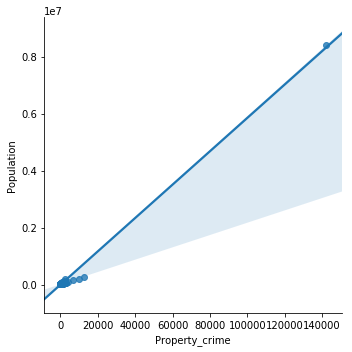

In [6]:
sns.lmplot(x='Property_crime', y='Population', data=df)

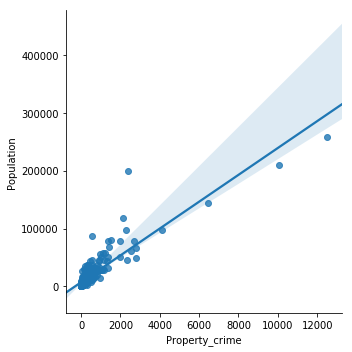

In [7]:
# Try graphing again with New York, the outlier, removed
sns.lmplot(x='Property_crime', y='Population', data=df.drop(index='New York'))

In [8]:
# That is much more manageable, so we will make the dropping of New York permanent
df = df.drop(index='New York')

In [9]:
# Now that the data is sufficiently cleaned, I will create the Population-squared feature
# and convert Murder and Robbery to categorical features with 0 or 1 values
df['Population_squared'] = df['Population'] ** 2

df['Murder'] = np.where(df['Murder']>0, 1, 0)
df['Robbery'] = np.where(df['Robbery']>0, 1, 0)

df.head(10)

,Population,Murder,Robbery,Property_crime,Population_squared
City,,,,,
Adams Village,1861,0,0,12,3463321
Addison Town and Village,2577,0,0,24,6640929
Akron Village,2846,0,0,16,8099716
Albany,97956,1,1,4090,9595377936
Albion Village,6388,0,1,223,40806544
Alfred Village,4089,0,1,46,16719921
Allegany Village,1781,0,0,10,3171961
Amherst Town,118296,1,1,2118,13993943616
Amityville Village,9519,0,1,210,90611361


In [10]:
# Finally, I will rearrange so that Population_squared is by population, and the target Property_crime is at the end
df = df[['Population', 'Population_squared', 'Murder', 'Robbery', 'Property_crime']]
df.head()

,Population,Population_squared,Murder,Robbery,Property_crime
City,,,,,
Adams Village,1861,3463321,0,0,12
Addison Town and Village,2577,6640929,0,0,24
Akron Village,2846,8099716,0,0,16
Albany,97956,9595377936,1,1,4090
Albion Village,6388,40806544,0,1,223


In [11]:
regr = linear_model.LinearRegression()
Y = df.Property_crime
X = df[['Population', 'Population_squared', 'Murder', 'Robbery']]
regr.fit(X, Y)

print('Coefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

Coefficients: 
 [1.29510871e-02 1.14920528e-07 1.95038666e+02 9.28205845e+01]

Intercept: 
 -16.815866321663066

R-squared:
0.8444937611173492


This is the model using the features I was asked to prepare previously. It seems that the presence of Murder and Robbery in a city have the most explanatory power in this model with very high numbers. Population, and even more, Population squared, do not seem to have as much affect on increasing property crime, but when you consider how large the population numbers are, it makes sense that the coefficient would be small. As long as it is a positive number, that means there is a correlated change. The R-squared value is .84, which seems to be a good high number without being too close to 1 and having overfitting problems.

## Test statistics

I will now run some test statistics on this original model. I will recreate this model in statsmodels for the ease of retrieving the the test statistics.

In [12]:
linear_formula = 'Property_crime ~ Population + Population_squared + Murder + Robbery'

lm = smf.ols(formula=linear_formula, data=df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         Property_crime   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     464.3
Date:                Wed, 20 Mar 2019   Prob (F-statistic):          8.94e-137
Time:                        13:45:49   Log-Likelihood:                -2577.7
No. Observations:                 347   AIC:                             5165.
Df Residuals:                     342   BIC:                             5185.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -16.8159     36

Two things to note. First, the p-value of the f-statistic is very small, 8.94e-137, so the model is statistically significant. I am going to do a more clear creation of the p-values of the parameters next, so I will address those in a moment. The second thing of note is the warning about multicollinearity. The p-value analysis I will do next will help determiner if I have unnecessary parameters.

In [13]:
lm.pvalues

Intercept             6.408973e-01
Population            5.765236e-09
Population_squared    1.727610e-24
Murder                1.137283e-02
Robbery               7.204162e-02
dtype: float64

Those p-values are all small, except for the intercept. I am guessing that this means that there is variance in the outcome that my features have not yet explained. I will do holdout and cross validation to see how the model performs. I will return to the sklearn model for this analysis.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, Y_train).score(X_test, Y_test)))

With 20% Holdout: 0.7325731556330537


The $R^2$ value is down to .73 with a 20% holdout. Not a good sign to begin with. Let's do some cross validation to see how it performs.

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(regr, X, Y, cv=10)

array([ 0.76250722,  0.93768963,  0.30362681,  0.82852633,  0.76061806,
        0.79761976,  0.55797032,  0.9025888 ,  0.84926351, -1.60913862])

That is a huge variance. I will run a cross validation with more folds just to see what that performance is like.

In [17]:
cross_val_score(regr, X, Y, cv=25)

array([ 0.78566843,  0.64687773,  0.94022192,  0.84262956,  0.94295722,
        0.71163392,  0.12435034,  0.78575161,  0.48119665,  0.89242399,
        0.86888393,  0.60491575,  0.19603182,  0.79633512,  0.87459932,
        0.5201315 ,  0.02566318,  0.6222801 ,  0.93370041,  0.89691386,
        0.76282896,  0.60701253,  0.82715031,  0.4804518 , -5.53855204])

The $R^2$ values are still all over the map. I clearly need to create better features. Let's start over with the data. I will perform some basic cleaning again, but I will leave all of the columns intact before deciding what to do with them.

## New Model

In [55]:
df_2 = pd.read_csv('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv', 
                 index_col='City',
                 names=['City', 'Population', 'Violent_crime', 'Murder', 'Rape_1', 'Rape_2',
                       'Robbery', 'Aggravated_assault', 'Property_crime', 'Burglary',
                       'Larceny_theft', 'Motor_vehicle_theft', 'Arson']
                )

df_2 = df_2.drop(index='City')

# Remove commas
df_2.Population = df_2.Population.str.replace(',', '')
df_2.Violent_crime = df_2.Violent_crime.str.replace(',', '')
df_2.Murder = df_2.Murder.str.replace(',', '')
df_2.Rape_1 = df_2.Rape_1.str.replace(',', '')
df_2.Rape_2 = df_2.Rape_2.str.replace(',', '')
df_2.Robbery = df_2.Robbery.str.replace(',', '')
df_2.Aggravated_assault = df_2.Aggravated_assault.str.replace(',', '')
df_2.Property_crime = df_2.Property_crime.str.replace(',', '')
df_2.Burglary = df_2.Burglary.str.replace(',', '')
df_2.Larceny_theft = df_2.Larceny_theft.str.replace(',', '')
df_2.Motor_vehicle_theft = df_2.Motor_vehicle_theft.str.replace(',', '')
df_2.Arson = df_2.Arson.str.replace(',', '')

# Force to be numbers
df_2.Population = pd.to_numeric(df_2.Population, errors='coerce')
df_2.Violent_crime = pd.to_numeric(df_2.Violent_crime, errors='coerce')
df_2.Murder = pd.to_numeric(df_2.Murder, errors='coerce')
df_2.Rape_1 = pd.to_numeric(df_2.Rape_1, errors='coerce')
df_2.Rape_2 = pd.to_numeric(df_2.Rape_2, errors='coerce')
df_2.Robbery = pd.to_numeric(df_2.Robbery, errors='coerce')
df_2.Aggravated_assault = pd.to_numeric(df_2.Aggravated_assault, errors='coerce')
df_2.Property_crime = pd.to_numeric(df_2.Property_crime, errors='coerce')
df_2.Burglary = pd.to_numeric(df_2.Burglary, errors='coerce')
df_2.Larceny_theft = pd.to_numeric(df_2.Larceny_theft, errors='coerce')
df_2.Motor_vehicle_theft = pd.to_numeric(df_2.Motor_vehicle_theft, errors='coerce')
df_2.Arson = pd.to_numeric(df_2.Arson, errors='coerce')

# Remove Rape 1 and Arson due to so many NaN values making them hard to create features out of
df_2 = df_2.dropna(axis=1, how='any')

df_2.head(10)

,Population,Violent_crime,Murder,Rape_2,Robbery,Aggravated_assault,Property_crime,Burglary,Larceny_theft,Motor_vehicle_theft
City,,,,,,,,,,
Adams Village,1861,0,0,0,0,0,12,2,10,0
Addison Town and Village,2577,3,0,0,0,3,24,3,20,1
Akron Village,2846,3,0,0,0,3,16,1,15,0
Albany,97956,791,8,30,227,526,4090,705,3243,142
Albion Village,6388,23,0,3,4,16,223,53,165,5
Alfred Village,4089,5,0,0,3,2,46,10,36,0
Allegany Village,1781,3,0,0,0,3,10,0,10,0
Amherst Town,118296,107,1,7,31,68,2118,204,1882,32
Amityville Village,9519,9,0,2,4,3,210,16,188,6


I am going to drop New York again. As I previously saw with population compared to property crimes, its values are so inflated that it has an outsized affect on the correlation. Let's remove it quickly and then check descriptive statistics for each variable.

In [57]:
df_2 = df_2.drop(index='New York')

df_2.describe()

,Population,Violent_crime,Murder,Rape_2,Robbery,Aggravated_assault,Property_crime,Burglary,Larceny_theft,Motor_vehicle_theft
count,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000
mean,15956.685879,51.213256,0.605187,2.677233,17.867435,30.063401,385.752161,72.172911,298.994236,14.585014
std,27080.218837,236.667435,3.707090,10.741020,94.972492,128.783376,1034.369072,264.941381,715.232296,67.682236
min,526.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2997.000000,2.000000,0.000000,0.000000,0.000000,1.000000,40.000000,6.000000,31.000000,0.000000
50%,7187.000000,6.000000,0.000000,0.000000,1.000000,4.000000,112.000000,17.000000,94.000000,2.000000
75%,18160.500000,21.500000,0.000000,2.000000,5.000000,14.000000,340.500000,51.000000,284.500000,7.000000
max,258789.000000,3249.000000,47.000000,145.000000,1322.000000,1735.000000,12491.000000,3458.000000,8076.000000,957.000000


I want to scale all of the features to the same scale. I will do that with the sklearn preprocessing package. I will check the descriptive statistics again after scaling.

In [59]:
names=df_2.columns

df_2_scaled = pd.DataFrame(preprocessing.scale(df_2), columns=names)

df_2_scaled.describe()

c:\users\ross last\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


,Population,Violent_crime,Murder,Rape_2,Robbery,Aggravated_assault,Property_crime,Burglary,Larceny_theft,Motor_vehicle_theft
count,3.470000e+02,3.470000e+02,347.000000,3.470000e+02,3.470000e+02,3.470000e+02,3.470000e+02,3.470000e+02,347.000000,3.470000e+02
mean,-2.047674e-17,-2.047674e-17,0.000000,-5.119184e-18,2.559592e-17,-5.119184e-18,3.583429e-17,1.535755e-17,0.000000,1.023837e-17
std,1.001444e+00,1.001444e+00,1.001444,1.001444e+00,1.001444e+00,1.001444e+00,1.001444e+00,1.001444e+00,1.001444,1.001444e+00
min,-5.706368e-01,-2.167058e-01,-0.163487,-2.496131e-01,-1.884044e-01,-2.337787e-01,-3.734733e-01,-2.728042e-01,-0.418642,-2.158037e-01
25%,-4.792576e-01,-2.082429e-01,-0.163487,-2.496131e-01,-1.884044e-01,-2.260025e-01,-3.347465e-01,-2.501250e-01,-0.375236,-2.158037e-01
50%,-3.243087e-01,-1.913172e-01,-0.163487,-2.496131e-01,-1.778598e-01,-2.026740e-01,-2.650383e-01,-2.085464e-01,-0.287026,-1.862112e-01
75%,8.149847e-02,-1.257299e-01,-0.163487,-6.314218e-02,-1.356816e-01,-1.249121e-01,-4.381174e-02,-8.003086e-02,-0.020294,-1.122299e-01
max,8.980096e+00,1.353124e+01,12.533229,1.326953e+01,1.375152e+01,1.325791e+01,1.171993e+01,1.279799e+01,10.889100,1.394422e+01


I will do a correlaation map of the variables to look for any that are at first glance well correlated to property crime and any that are redundant to each other.

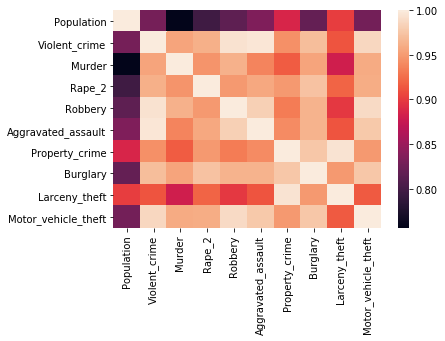

In [60]:
corrmat = df_2_scaled.corr()
sns.heatmap(corrmat)

I see some variables that are interesting for further analysis. I will do a series of line plots to check for relationship with property crime.

c:\users\ross last\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


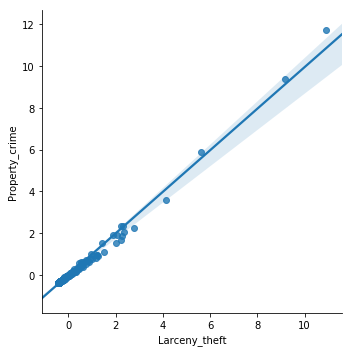

In [61]:
sns.lmplot(x='Larceny_theft', y='Property_crime', data=df_2_scaled)

Thats a good looking line with a narrower confidence interval and the values very close to the line. I will keep that as a feature.

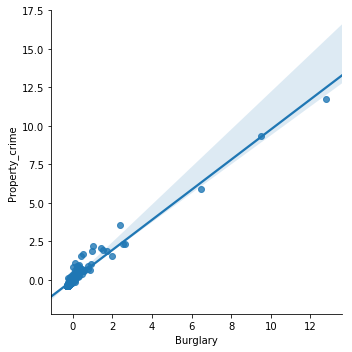

In [62]:
sns.lmplot(x='Burglary', y='Property_crime', data=df_2_scaled)

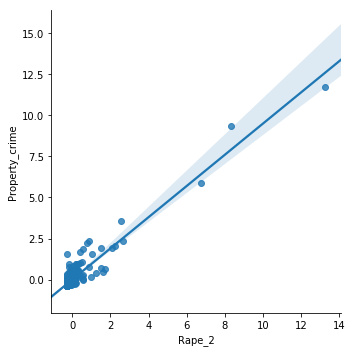

In [63]:
sns.lmplot(x='Rape_2', y='Property_crime', data=df_2_scaled)

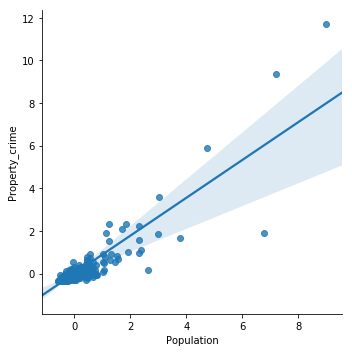

In [64]:
sns.lmplot(x='Population', y='Property_crime', data=df_2_scaled)

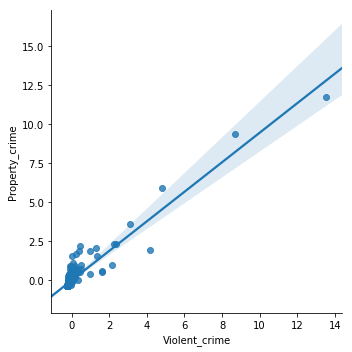

In [65]:
sns.lmplot(x='Violent_crime', y='Property_crime', data=df_2_scaled)

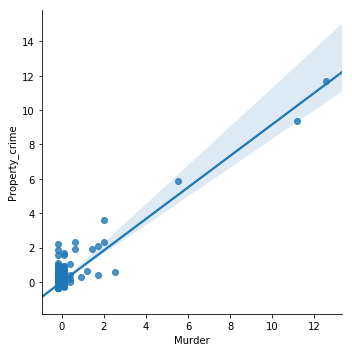

In [66]:
sns.lmplot(x='Murder', y='Property_crime', data=df_2_scaled)

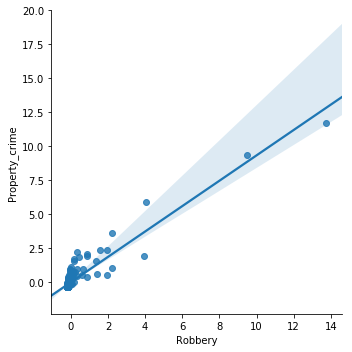

In [67]:
sns.lmplot(x='Robbery', y='Property_crime', data=df_2_scaled)

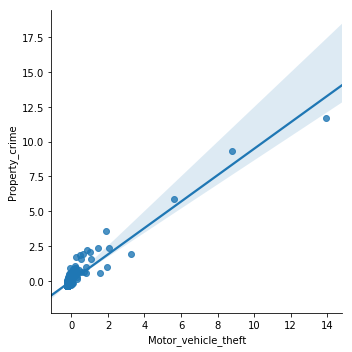

In [69]:
sns.lmplot(x='Motor_vehicle_theft', y='Property_crime', data=df_2_scaled)

Based on my analysis of the graphs and charts, I am going to use Population, Larceny-theft, and Burglary, and Motor vehicle theft. 

In [70]:
regr = linear_model.LinearRegression()
Y_2 = df_2_scaled.Property_crime
X_2 = df_2_scaled[['Population', 'Larceny_theft', 'Burglary', 'Motor_vehicle_theft']]
regr.fit(X_2, Y_2)

print('Coefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_2, Y_2))

Coefficients: 
 [-2.94571946e-15  6.91467209e-01  2.56138150e-01  6.54333525e-02]

Intercept: 
 3.1230702143047356e-17

R-squared:
1.0


I have accomlished an $R^2$ of 1.0. This is actually not a great thing, since I am now worried about overfitting. I am going to remove Motor vehicle theft and Burglary as features to see if the $R^2$ gets to a better spot with only two features.

In [75]:
regr = linear_model.LinearRegression()
Y_2 = df_2_scaled.Property_crime
X_2 = df_2_scaled[['Population', 'Larceny_theft']]
regr.fit(X_2, Y_2)

print('Coefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_2, Y_2))

Coefficients: 
 [-0.04828853  1.03814826]

Intercept: 
 3.484549627068366e-17

R-squared:
0.9897314893859629


This is somewhat better. I am going to, check on the f-test statistic and p-values using the statsmodel version of linear regression, then run my holdout and cross validations to check on performance of this model.

In [76]:
linear_formula_2 = 'Property_crime ~ Population + Larceny_theft'

lm_2 = smf.ols(formula=linear_formula_2, data=df_2_scaled).fit()
print(lm_2.summary())

                            OLS Regression Results                            
Dep. Variable:         Property_crime   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.658e+04
Date:                Thu, 21 Mar 2019   Prob (F-statistic):               0.00
Time:                        18:18:31   Log-Likelihood:                 302.03
No. Observations:                 347   AIC:                            -598.1
Df Residuals:                     344   BIC:                            -586.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3.017e-17      0.005   5.52e-15

In [77]:
from sklearn.model_selection import train_test_split

X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X_2, Y_2, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train_2, Y_train_2).score(X_test_2, Y_test_2)))

With 20% Holdout: 0.9600862669204927


This is a good sign, still a great $R^2$. Let's do the cross validation.

In [78]:
from sklearn.model_selection import cross_val_score
cross_val_score(regr, X_2, Y_2, cv=10)

array([0.96927033, 0.98694463, 0.95959762, 0.95093152, 0.96480044,
       0.9753538 , 0.97290458, 0.99767457, 0.99581406, 0.95893679])

The model is performing great. The final test is to check it on completely new data from a different year.

In [97]:
# Create new df with data from new year. Clean as previously, but only the inputs for predicting in the model
df_3 = pd.read_csv('New_York_by_City_2014.csv',
                  index_col='City',
                   names=['City', 'Population', 'Violent_crime', 'Murder', 'Rape_1', 'Rape_2',
                       'Robbery', 'Aggravated_assault', 'Property_crime', 'Burglary',
                       'Larceny_theft', 'Motor_vehicle_theft', 'Arson']
                  )

df_3 = df_3.drop(index='City')

# Remove commas
df_3.Population = df_3.Population.str.replace(',', '')
df_3.Larceny_theft = df_3.Larceny_theft.str.replace(',', '')
df_3.Property_crime = df_3.Property_crime.str.replace(',', '')

# Force to be numbers
df_3.Population = pd.to_numeric(df_3.Population, errors='coerce')
df_3.Larceny_theft = pd.to_numeric(df_3.Larceny_theft, errors='coerce')
df_3.Property_crime = pd.to_numeric(df_3.Property_crime, errors='coerce')

df_3 = df_3.drop(index='New York4')

# Make data only needed inputs
df_3 = df_3[['Population', 'Larceny_theft', 'Property_crime']]

# Drop cities with NaN
df_3 = df_3.dropna(axis=0, how='any')

df_3.head()

,Population,Larceny_theft,Property_crime
City,,,
Adams Village,1851.0,10.0,11.0
Addison Town and Village,2568.0,47.0,49.0
Afton Village4,820.0,1.0,1.0
Akron Village,2842.0,17.0,17.0
Albany4,98595.0,3083.0,3888.0


In [98]:
Y_new = df_3.Property_crime
X_new = df_3[['Population', 'Larceny_theft']]

print('Model performance With New Year Data: ' + str(regr.fit(X_2, Y_2).score(X_new, Y_new)))

Model performance With New Year Data: -2.1421001938800344


This is a disappointing result. 

JOSE- Can you help me figure out what I can do to make my features better so that I can have a model that works on new data? I've been going at this one for awhile. But I want to rework it so that I can get to the point where I have a good result when scoring on new data.